In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import re
import ast

import pickle

from concurrent.futures import ProcessPoolExecutor

from scipy import integrate
from scipy.spatial import Voronoi
#import pandas as pd

def find_centroids(image):
    """
    Find the centroids of white dots in a binary image.
    
    Args:
        image (numpy.ndarray): The binary image array (256x256) with 0s and 1s.

    Returns:
        List[Tuple[int, int]]: List of centroids (x, y) of the white dots.
    """
    border_width = 10
    larger_image_size = 256 + 2 * border_width
    
    # Create a larger image
    larger_image = np.zeros((larger_image_size, larger_image_size), dtype=np.uint8)
    larger_image[border_width:border_width+256, border_width:border_width+256] = image
    
    # Copy borders
    larger_image[0:border_width, border_width:border_width+256] = image[-border_width:, :]
    larger_image[border_width+256:border_width+256+border_width, border_width:border_width+256] = image[:border_width, :]
    larger_image[border_width:border_width+256, 0:border_width] = image[:, -border_width:]
    larger_image[border_width:border_width+256, border_width+256:border_width+256+border_width] = image[:, :border_width]
    larger_image[0:border_width, 0:border_width] = image[-border_width:, -border_width:]
    larger_image[0:border_width, border_width+256:border_width+256+border_width] = image[-border_width:, :border_width]
    larger_image[border_width+256:border_width+256+border_width, 0:border_width] = image[:border_width, -border_width:]
    larger_image[border_width+256:border_width+256+border_width, border_width+256:border_width+256+border_width] = image[:border_width, :border_width]

    # Connected component analysis
    num_labels, VoidSmall_labels, stats, centroids = cv2.connectedComponentsWithStats(larger_image, connectivity=4)

    # Filter centroids within the original image bounds
    valid_centroids = [
        (x - border_width, y - border_width)
        for i in range(1, num_labels)  # Skip the background label (0)
        if border_width <= (x := centroids[i][0]) < border_width + 256 and
           border_width <= (y := centroids[i][1]) < border_width + 256
    ]

    return valid_centroids

def process_images(images):
    """
    Process a list of images to find centroids of white dots in each image.
    Uses a progress bar for feedback.

    Args:
        images (List[numpy.ndarray]): List of binary images (256x256) with 0s and 1s.

    Returns:
        List[List[Tuple[int, int]]]: List of centroid lists for each image.
    """
    all_centroids = []

    for image in tqdm(images, desc="Processing Images", unit="image"):
        centroids = find_centroids(image)
        all_centroids.append(centroids)

    return all_centroids

def calculate_volume_fraction(image):
    """
    Calculate the ratio of white pixels (pixel value of 1) to the total number of pixels in the image.

    Args:
        image (numpy.ndarray): Binary image array (256x256) with values 0 (black) and 1 (white).

    Returns:
        float: Ratio of white pixels to total pixels.
    """
    # Ensure the image has dtype uint8 (optional step)
    #image = np.asarray(image, dtype=np.uint8)
    
    # Calculate total number of pixels
    total_pixels = 256*256
    
    # Calculate number of white pixels
    white_pixels = np.count_nonzero(image == 1)
    
    # Calculate ratio of white pixels to total pixels
    vf = white_pixels / total_pixels
    
    return vf

def clean_value(value):
    # Remove trailing backslashes and quotes
    value = value.rstrip('\\').rstrip('"').rstrip("'")
    # Remove trailing dots if not part of a number
    if not value.replace('.', '').isdigit():
        value = value.rstrip('.')
    value = value.rstrip('.')    
    return value

def parse_vector(vector_bytes):
    # Decode bytes to string and remove outer quotes and b prefix
    cleaned_str = vector_bytes.decode('utf-8').strip('b"\'')
    
    # Split into main content and Local State
    parts = cleaned_str.split('Local State:', 1)
    main_content = parts[0].strip()
    local_state = parts[1].strip() if len(parts) > 1 else None
    
    result = {'Local State': clean_value(local_state)} if local_state else {}
    
    # Split main content into lines
    lines = main_content.split('\\n')
    
    for line in lines:
        if ':' in line:
            key, value = line.split(':', 1)
            key = key.strip()
            value = clean_value(value.strip())
            
            # Try to convert value to appropriate type
            try:
                value = ast.literal_eval(value)
            except (ValueError, SyntaxError):
                # If conversion fails, keep as string
                pass
            
            result[key] = value
    
    return result

def parse_all_vectors(vectors):
    return [parse_vector(vector) for vector in vectors]

def calculate_2D_orthotropic_C_matrix(E_x, v_xy, E_y, v_yx, G_xy):
    
    denominator = 1 - v_xy * v_yx
    C11 = E_x / denominator
    C12 = v_yx * E_x / denominator
    C21 = v_xy * E_y / denominator
    C22 = E_y / denominator
    C33 = G_xy

    C = np.array([[C11, C12, 0],
                  [C21, C22, 0],
                  [0, 0, C33]])
    
    return C

# K_from_E_nu = lambda E,nu: E/(3.*(1.-2.*nu)) # 3D
K_from_E_nu = lambda E,nu: E/(2.*(1.-nu)) # 2D plane stress
mu_from_E_nu = lambda E,nu: E/(2.*(1.+nu))
E_from_K_mu = lambda K,mu: 9.*K*mu/(3.*K+mu)
nu_from_K_mu = lambda K,mu: (3.*K-2.*mu)/(2.*(3.*K+mu))

class Material:
    def __init__(self, E, nu):
        self.E = E
        self.nu = nu
        self.mu = mu_from_E_nu(E,nu)
        self.K = K_from_E_nu(E,nu)

def A_coefficients(K,mu):
    s_1 = 3. * K / (3.*K + 4.*mu)
    s_2 = 6. * (K + 2.*mu)/(5. * (3.*K + 4.*mu))
    return s_1, s_2

def Voigt(K,mu,f):
    K_star = 0; mu_star = 0
    for i in range(len(f)):
        K_star  += f[i] * K[i]
        mu_star += f[i] * mu[i]
    return K_star, mu_star

def Reuss(K,mu,f):
    K_star = 0; mu_star = 0
    for i in range(len(f)):
        K_star  += f[i] / K[i]
        mu_star += f[i] / mu[i]
    return 1/K_star, 1/mu_star

def HS(K,mu,f,K_0,mu_0):
    K_star = 0; mu_star = 0; K_star_ = 0; mu_star_ = 0
    s_1, s_2 = A_coefficients(K_0,mu_0)
    for i in range(len(f)):
        if i > 0:
            K_star  += f[i] * (K[i]  - K[0])  / (1 + s_1 * (K[i]/K_0 - 1))
            mu_star += f[i] * (mu[i] - mu[0]) / (1 + s_2 * (mu[i]/mu_0 - 1))   

        K_star_  += (f[i] * (1 / (1 + s_1 * (K[i]/K_0 - 1))))
        mu_star_ += (f[i] * (1 / (1 + s_2 * (mu[i]/mu_0 - 1))))

    return K_star/K_star_ + K[0], mu_star/mu_star_ + mu[0]

def DD_E(K,mu,f):
    K_star = 0; mu_star = 0
    s_1, s_2 = A_coefficients(K[0],mu[0])
    for i in range(len(f)):
        if i > 0:
            K_star  += f[i] * (K[i]  - K[0])  / (1 + s_1 * (K[i]/K[0] - 1))
            mu_star += f[i] * (mu[i] - mu[0]) / (1 + s_2 * (mu[i]/mu[0] - 1)) 

    return K_star + K[0], mu_star + mu[0]

def SC(K,mu,f):
    tolerance = 1e-6
    max_iterations = 100
    k = 0
    K_SC, mu_SC = HS(K,mu,f,K[0],mu[0])

    def SC_fun(K_star,mu_star,f):
        K_star_1 = 0; mu_star_1 = 0; K_star_2 = 0; mu_star_2 = 0
        s_1, s_2 = A_coefficients(K_star,mu_star)
        for i in range(len(f)):
            if i > 0:
                K_star_1  += f[i] * (K[i]  - K[0])  / (1 + s_1 * (K[i]/K_star - 1))
                mu_star_1 += f[i] * (mu[i] - mu[0]) / (1 + s_2 * (mu[i]/mu_star - 1))   

            K_star_2  += f[i] * (1 / (1 + s_1 * (K[i]/K_star - 1)))
            mu_star_2 += f[i] * (1 / (1 + s_2 * (mu[i]/mu_star - 1)))

        return K_star_1/K_star_2 + K[0], mu_star_1/mu_star_2 + mu[0]

    for i in range(max_iterations):
        K_new, mu_new = SC_fun(K_SC,mu_SC,f)
        if (abs(K_new - K_SC) < tolerance) and (abs(mu_new - mu_SC) < tolerance):
            break
        K_SC, mu_SC = K_new, mu_new
        k += 1
    return K_SC, mu_SC

def diff(K,mu,f,xi):
    y0 = [K[0], mu[0]]

    t0 = 0
    tfinal = 1 - f[0]
    ts = np.linspace(t0, tfinal, 100)

    def diff_fun(c_i,y,):
        K_star, mu_star = y
        K_sum, mu_sum = 0.0, 0.0
        f_bar_i = [x / (1-c_i) for x in xi]
        s_1, s_2 = A_coefficients(K_star,mu_star)
        for i in range(len(f_bar_i)):
            K_sum  += f_bar_i[i] * (K[i+1]  - K_star)  / (1 + s_1 * (K[i+1]/K_star - 1))  
            mu_sum += f_bar_i[i] * (mu[i+1] - mu_star) / (1 + s_2 * (mu[i+1]/mu_star - 1))
        K_star  = K_sum 
        mu_star = mu_sum
        return [K_star, mu_star]

    sol = integrate.solve_ivp(diff_fun,[0,tfinal],y0, t_eval=ts,method='RK45')
    return sol.y[0,-1], sol.y[1,-1]

class MFA:
    def __init__(self,materials,f,xi,method):
        self.method = method
        self.K = [x.K for x in materials]
        self.mu = [x.mu for x in materials]
        self.f = f
        self.xi = xi

        self.K_star, self.mu_star = self.Homogenize()

    def Homogenize(self):
        K_star = 0; mu_star = 0
        K = self.K; mu = self.mu
        f = self.f
        method = self.method
        if method == 'Voigt':
            K_star, mu_star = Voigt(K,mu,f)
        elif method == 'Reuss':
            K_star, mu_star = Reuss(K,mu,f)
        elif method == 'MT':
            K_0 = K[0]
            mu_0 = mu[0]
            K_star, mu_star = HS(K,mu,f,K_0,mu_0)
        elif method == 'HS+':
            K_0 = np.max(K)
            mu_0 = np.max(mu)
            K_star, mu_star = HS(K,mu,f,K_0,mu_0)
        elif method == 'HS-':
            K_0 = np.min(K)
            mu_0 = np.min(mu)
            K_star, mu_star = HS(K,mu,f,K_0,mu_0)
        elif method == 'DD:E':
            K_0 = K[0]
            mu_0 = mu[0]
            K_star, mu_star = DD_E(K,mu,f)
        elif method == 'SC':
            K_star, mu_star = SC(K,mu,f)
        elif method == 'Diff':
            K_star, mu_star = diff(K,mu,f,self.xi)
        else:
            print('Method not recognized')
        
        return K_star, mu_star


def calculate_2D_isotropic_C_Reuss(E_fiber,E_matrix,vf):
    #K_matrix = K_from_E_nu(E_matrix,0.3); K_fiber = K_from_E_nu(E_fiber,0.3)
    mu_matrix = mu_from_E_nu(E_matrix,0.3); mu_fiber = mu_from_E_nu(E_fiber,0.3)
    #K_Reuss = 1/(vf/K_fiber + (1-vf)/K_matrix)
    mu_Reuss = 1/(vf/mu_fiber + (1-vf)/mu_matrix)
    kappa = (3 - 0.3)/(1 + 0.3) # plane stress, nu = 0.3

    C11 = (kappa + 1)/(kappa - 1)
    C12 = -(kappa - 3)/(kappa - 1)
    C33 = 1

    C = np.array([[C11, C12, 0],
                  [C12, C11, 0],
                  [0, 0, C33]]) * mu_Reuss
    return C

def calculate_2D_isotropic_C_Voight(E_fiber,E_matrix,vf):
    #K_matrix = K_from_E_nu(E_matrix,0.3); K_fiber = K_from_E_nu(E_fiber,0.3)
    mu_matrix = mu_from_E_nu(E_matrix,0.3); mu_fiber = mu_from_E_nu(E_fiber,0.3)
    #K_Reuss = vf*K_fiber + (1-vf)*K_matrix
    # mu_Reuss = vf*mu_fiber + (1-vf)*mu_matrix
    kappa = (3 - 0.3)/(1 + 0.3) # plane stress, nu = 0.3

    C11 = (kappa + 1)/(kappa - 1)
    C12 = -(kappa - 3)/(kappa - 1)
    C33 = 1

    C_base = np.array([[C11, C12, 0],
                       [C12, C11, 0],
                       [0, 0, C33]])
    
    C_matrix = C_base * mu_matrix
    C_fiber  = C_base * mu_fiber
    C_Voight = vf * C_fiber + (1 - vf) * C_matrix
    
    return C_Voight
contrast_ratios_mfa = [[1.E3, 10.E3],
                       [1.E3, 100.E3],
                       [1.E3, 1000.E3],
                       [10.E3, 1.E3],
                       [100.E3, 1.E3],
                       [1000.E3, 1.E3]]
def MFA_C_matrix(r_index, vf, method):
    materials = []
    for r in contrast_ratios_mfa[r_index]:
        materials.append(Material(E=r, nu=0.3))
    mfa = MFA(materials=materials,
              f=[1-vf, vf],
              xi=[1],
              method=method)
    K, mu = mfa.K_star, mfa.mu_star
    E, nu = E_from_K_mu(K, mu), nu_from_K_mu(K, mu)
    C = calculate_2D_orthotropic_C_matrix(E, nu, E, nu, mu)
    return C

def flatten_C(C):
    return [C[0,0], C[0,1], C[1,1], C[2,2]]

#def calculate_coef(labels,properties,r_index):
#    mfa_c = calculate_2D_isotropic_C_Voight(*contrast_ratios_fem[r_index], labels["Vf"])
#    inverse_mfa_c = np.linalg.inv(mfa_c)
#    fem_c = calculate_2D_orthotropic_C_matrix(*properties[r_index])
#    coef = np.identity(3) - inverse_mfa_c @ fem_c
#    return [flatten_C(coef), flatten_C(fem_c), flatten_C(mfa_c)]

def calculate_mfa_coef(labels,properties,r_index,mfa_c):
    #mfa_c = calculate_2D_isotropic_C_Voight(*contrast_ratios[r_index], labels["Vf"])
    inverse_mfa_c = np.linalg.inv(mfa_c)
    fem_c = calculate_2D_orthotropic_C_matrix(*properties[r_index])
    coef = np.identity(3) - inverse_mfa_c @ fem_c
    return [flatten_C(coef), flatten_C(fem_c), flatten_C(mfa_c)]


In [2]:
def mfa_iso(r_index,vf,method):
    materials = []
    for r in contrast_ratios_mfa[r_index]:
        materials.append(Material(E=r, nu=0.3))
    mfa = MFA(materials=materials,
              f=[1-vf, vf],
              xi=[1],
              method=method)
    K, mu = mfa.K_star, mfa.mu_star
    return K, mu
def calculate_mfa_coef_iso(iso_data,mfa_c_iso):
    #mfa_c = calculate_2D_isotropic_C_Voight(*contrast_ratios[r_index], labels["Vf"])
    inverse_mfa_c = 1/mfa_c_iso
    coef = 1 - inverse_mfa_c*iso_data
    return coef

In [3]:
MICRO2D_homogenized = h5py.File("MICRO2D_homogenized.h5", "r")
VoidSmall = MICRO2D_homogenized["VoidSmall"]

methods = ['Reuss', 'Voigt', 'HS-', 'HS+', 'MT',  'SC', 'Diff']  # ,'DD:E' #  

indexses = [1434, 2229, 3013, 4921,5502, 5670, 5956, 5989, 6250, 6270, 7425, 8099, 8294, 8361, 9358]

VoidSmall_parsed_labels = [label for i, label in enumerate(parse_all_vectors(VoidSmall["VoidSmall - labels"])) if i not in indexses]
VoidSmall_centroids = [centroids for i, centroids in enumerate(process_images(VoidSmall["VoidSmall"])) if i not in indexses]

VoidSmall_num_centroids = [len(image_centroids) for image_centroids in VoidSmall_centroids]
VoidSmall_average_centroids = sum(VoidSmall_num_centroids) / len(VoidSmall_num_centroids)
VoidSmall_volume_fractions = [calculate_volume_fraction(image) for i, image in enumerate(VoidSmall["VoidSmall"]) if i not in indexses]
VoidSmall_radius = [5.5 for _ in range(len(VoidSmall_num_centroids))]

VoidSmall_ratio = [VoidSmall_num_centroids[i] / VoidSmall_volume_fractions[i] for i in range(len(VoidSmall_num_centroids))]
VoidSmall_indexes = np.where(np.array(VoidSmall_ratio) < 809)[0]

for i in range(len(VoidSmall_parsed_labels)):
    VoidSmall_parsed_labels[i]['centroids'] = VoidSmall_centroids[i]
    VoidSmall_parsed_labels[i]['num_centroids'] = VoidSmall_num_centroids[i]
    VoidSmall_parsed_labels[i]['calculated_vf'] = VoidSmall_volume_fractions[i]
    VoidSmall_parsed_labels[i]['radius'] = VoidSmall_radius[i]

MFA_results = {}
true_vfs = [label['Vf'] for label in VoidSmall_parsed_labels]

for r_index in range(6):
    MFA_results[r_index] = {}
    for method in (methods):
        print(method)
        MFA_results[r_index][method] = {}
        for vf in tqdm(true_vfs):
            C_matrix = MFA_C_matrix(r_index, vf, method)
            MFA_results[r_index][method][vf] = C_matrix

Processing Images: 100%|██████████| 9989/9989 [00:26<00:00, 381.18image/s]


Reuss


100%|██████████| 9974/9974 [00:00<00:00, 241237.66it/s]


Voigt


100%|██████████| 9974/9974 [00:00<00:00, 249819.29it/s]


HS-


100%|██████████| 9974/9974 [00:00<00:00, 72330.59it/s]


HS+


100%|██████████| 9974/9974 [00:00<00:00, 71318.59it/s]


MT


100%|██████████| 9974/9974 [00:00<00:00, 201778.78it/s]


SC


100%|██████████| 9974/9974 [00:00<00:00, 59249.07it/s]


Diff


100%|██████████| 9974/9974 [00:02<00:00, 3812.06it/s]


Reuss


100%|██████████| 9974/9974 [00:00<00:00, 260740.50it/s]


Voigt


100%|██████████| 9974/9974 [00:00<00:00, 258496.18it/s]


HS-


100%|██████████| 9974/9974 [00:00<00:00, 71697.87it/s]


HS+


100%|██████████| 9974/9974 [00:00<00:00, 77621.71it/s]


MT


100%|██████████| 9974/9974 [00:00<00:00, 205897.20it/s]


SC


100%|██████████| 9974/9974 [00:00<00:00, 36998.11it/s]


Diff


100%|██████████| 9974/9974 [00:02<00:00, 3959.73it/s]


Reuss


100%|██████████| 9974/9974 [00:00<00:00, 233774.73it/s]


Voigt


100%|██████████| 9974/9974 [00:00<00:00, 239898.55it/s]


HS-


100%|██████████| 9974/9974 [00:00<00:00, 74521.77it/s]


HS+


100%|██████████| 9974/9974 [00:00<00:00, 74481.30it/s]


MT


100%|██████████| 9974/9974 [00:00<00:00, 206651.89it/s]


SC


100%|██████████| 9974/9974 [00:00<00:00, 26953.93it/s]


Diff


100%|██████████| 9974/9974 [00:02<00:00, 4003.55it/s]


Reuss


100%|██████████| 9974/9974 [00:00<00:00, 236374.25it/s]


Voigt


100%|██████████| 9974/9974 [00:00<00:00, 257167.72it/s]


HS-


100%|██████████| 9974/9974 [00:00<00:00, 78058.10it/s]


HS+


100%|██████████| 9974/9974 [00:00<00:00, 75064.66it/s]


MT


100%|██████████| 9974/9974 [00:00<00:00, 207378.19it/s]


SC


100%|██████████| 9974/9974 [00:00<00:00, 58157.20it/s]


Diff


100%|██████████| 9974/9974 [00:02<00:00, 3790.52it/s]


Reuss


100%|██████████| 9974/9974 [00:00<00:00, 242423.12it/s]


Voigt


100%|██████████| 9974/9974 [00:00<00:00, 242870.68it/s]


HS-


100%|██████████| 9974/9974 [00:00<00:00, 72469.42it/s]


HS+


100%|██████████| 9974/9974 [00:00<00:00, 76119.65it/s]


MT


100%|██████████| 9974/9974 [00:00<00:00, 212771.09it/s]


SC


100%|██████████| 9974/9974 [00:00<00:00, 34753.46it/s]


Diff


100%|██████████| 9974/9974 [00:03<00:00, 2642.21it/s]


Reuss


100%|██████████| 9974/9974 [00:00<00:00, 246514.41it/s]


Voigt


100%|██████████| 9974/9974 [00:00<00:00, 255990.63it/s]


HS-


100%|██████████| 9974/9974 [00:00<00:00, 74058.71it/s]


HS+


100%|██████████| 9974/9974 [00:00<00:00, 68936.63it/s]


MT


100%|██████████| 9974/9974 [00:00<00:00, 198921.50it/s]


SC


100%|██████████| 9974/9974 [00:00<00:00, 24287.63it/s]


Diff


100%|██████████| 9974/9974 [00:02<00:00, 3587.27it/s]


In [4]:
homogenized_mechanical = [[list(val) for val in list(VoidSmall['homogenized_mechanical'][i])] for i in range(len(VoidSmall['homogenized_mechanical'])) if i not in indexses]
imgs = [VoidSmall['VoidSmall'][i] for i in range(len(VoidSmall['VoidSmall'])) if i not in indexses]

In [5]:
for i in range(len(VoidSmall_parsed_labels)):
    coef  = []
    coef_diff = []
    coef_mt = []
    coef_sc = []
    coef_hsp = []
    coef_hsn = []
    coef_r = []
    coef_v = []
    c_fem = []
    c_mfa = []
    c_diff = []
    c_mt = []
    c_sc = []
    c_hsp = []
    c_hsn = []
    c_r = []
    c_v = []
    for r in range(6):
        coef_, c_fem_, c_mfa_ = calculate_mfa_coef(VoidSmall_parsed_labels[i], homogenized_mechanical[i], r_index=r,mfa_c=MFA_results[r]['Diff'][VoidSmall_parsed_labels[i]['Vf']])
        coef_diff_, c_fem_, c_mfa_diff = calculate_mfa_coef(VoidSmall_parsed_labels[i], homogenized_mechanical[i], r_index=r,mfa_c=MFA_results[r]['Diff'][VoidSmall_parsed_labels[i]['Vf']])
        coef_mt_, c_fem_, c_mfa_mt = calculate_mfa_coef(VoidSmall_parsed_labels[i], homogenized_mechanical[i], r_index=r,mfa_c=MFA_results[r]['MT'][VoidSmall_parsed_labels[i]['Vf']])
        coef_sc_, c_fem_, c_mfa_sc = calculate_mfa_coef(VoidSmall_parsed_labels[i], homogenized_mechanical[i], r_index=r,mfa_c=MFA_results[r]['SC'][VoidSmall_parsed_labels[i]['Vf']])
        coef_hsp_, c_fem_, c_mfa_hsp = calculate_mfa_coef(VoidSmall_parsed_labels[i], homogenized_mechanical[i], r_index=r,mfa_c=MFA_results[r]['HS+'][VoidSmall_parsed_labels[i]['Vf']])
        coef_hsn_, c_fem_, c_mfa_hsn = calculate_mfa_coef(VoidSmall_parsed_labels[i], homogenized_mechanical[i], r_index=r,mfa_c=MFA_results[r]['HS-'][VoidSmall_parsed_labels[i]['Vf']])
        coef_r_, c_fem_, c_mfa_r = calculate_mfa_coef(VoidSmall_parsed_labels[i], homogenized_mechanical[i], r_index=r,mfa_c=MFA_results[r]['Reuss'][VoidSmall_parsed_labels[i]['Vf']])
        coef_v_, c_fem_, c_mfa_v = calculate_mfa_coef(VoidSmall_parsed_labels[i], homogenized_mechanical[i], r_index=r,mfa_c=MFA_results[r]['Voigt'][VoidSmall_parsed_labels[i]['Vf']])
        coef.append(coef_)
        coef_diff.append(coef_diff_)
        coef_mt.append(coef_mt_)
        coef_sc.append(coef_sc_)
        coef_hsp.append(coef_hsp_)
        coef_hsn.append(coef_hsn_)
        coef_r.append(coef_r_)
        coef_v.append(coef_v_)
        c_fem.append(c_fem_)
        c_mfa.append(c_mfa_)
        c_diff.append(c_mfa_diff)
        c_mt.append(c_mfa_mt)
        c_sc.append(c_mfa_sc)
        c_hsp.append(c_mfa_hsp)
        c_hsn.append(c_mfa_hsn)
        c_r.append(c_mfa_r)
        c_v.append(c_mfa_v)
    VoidSmall_parsed_labels[i]['C_coefs'] = coef
    VoidSmall_parsed_labels[i]['C_coefs_diff'] = coef_diff
    VoidSmall_parsed_labels[i]['C_coefs_mt'] = coef_mt
    VoidSmall_parsed_labels[i]['C_coefs_sc'] = coef_sc
    VoidSmall_parsed_labels[i]['C_coefs_hsp'] = coef_hsp
    VoidSmall_parsed_labels[i]['C_coefs_hsn'] = coef_hsn
    VoidSmall_parsed_labels[i]['C_coefs_r'] = coef_r
    VoidSmall_parsed_labels[i]['C_coefs_v'] = coef_v
    VoidSmall_parsed_labels[i]['C_fem'] = c_fem
    VoidSmall_parsed_labels[i]['C_mfa'] = c_mfa
    VoidSmall_parsed_labels[i]['C_diff'] = c_diff
    VoidSmall_parsed_labels[i]['C_mt'] = c_mt
    VoidSmall_parsed_labels[i]['C_sc'] = c_sc
    VoidSmall_parsed_labels[i]['C_hsp'] = c_hsp
    VoidSmall_parsed_labels[i]['C_hsn'] = c_hsn
    VoidSmall_parsed_labels[i]['C_r'] = c_r
    VoidSmall_parsed_labels[i]['C_v'] = c_v
    VoidSmall_parsed_labels[i]['img'] = imgs[i]
    

In [6]:
VoidSmall_r = [E[1]/E[0] for E in contrast_ratios_mfa]
for i in range(len(VoidSmall_parsed_labels)):
    VoidSmall_parsed_labels[i]['contrast_ratios'] = VoidSmall_r

In [7]:
def polygeom(x, y):
    """
    Geometry of a planar polygon
 
    Parameters:
    x, y : array-like
        Coordinates of vertices of the polygon
 
    Returns:
    geom : ndarray
        [area, x_centroid, y_centroid, perimeter]
    iner : ndarray
        [Ixx, Iyy, Ixy, Iuu, Ivv, Iuv]
        u,v are centroidal axes parallel to x,y axes.
    cpmo : ndarray
        [I1, ang1, I2, ang2, J]
        I1,I2 are centroidal principal moments about axes at angles ang1,ang2.
        ang1 and ang2 are in radians.
        J is centroidal polar moment. J = I1 + I2 = Iuu + Ivv
    """
 
    # Check if inputs are the same size
    if len(x) != len(y):
        raise ValueError('X and Y must be the same size')
 
    # Ensure x and y are numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)
 
    # Number of vertices
    n = len(x)
 
    # Temporarily shift data to mean of vertices for improved accuracy
    xm = np.mean(x)
    ym = np.mean(y)
    x = x - xm
    y = y - ym
 
    # Delta x and delta y
    dx = np.roll(x, -1) - x
    dy = np.roll(y, -1) - y
 
    # Summations for CW boundary integrals
    A = np.sum(y * dx - x * dy) / 2
    Axc = np.sum(6 * x * y * dx - 3 * x * x * dy + 3 * y * dx * dx + dx * dx * dy) / 12
    Ayc = np.sum(3 * y * y * dx - 6 * x * y * dy - 3 * x * dy * dy - dx * dy * dy) / 12
    Ixx = np.sum(2 * y**3 * dx - 6 * x * y**2 * dy - 6 * x * y * dy**2 
                 - 2 * x * dy**3 - 2 * y * dx * dy**2 - dx * dy**3) / 12
    Iyy = np.sum(6 * x**2 * y * dx - 2 * x**3 * dy + 6 * x * y * dx**2 
                 + 2 * y * dx**3 + 2 * x * dx**2 * dy + dx**3 * dy) / 12
    Ixy = np.sum(6 * x * y**2 * dx - 6 * x**2 * y * dy + 3 * y**2 * dx**2 
                 - 3 * x**2 * dy**2 + 2 * y * dx**2 * dy - 2 * x * dx * dy**2) / 24
    P = np.sum(np.sqrt(dx**2 + dy**2))
 
    # Check for CCW versus CW boundary
    if A < 0:
        A, Axc, Ayc, Ixx, Iyy, Ixy = [-A, -Axc, -Ayc, -Ixx, -Iyy, -Ixy]
 
    # Centroidal moments
    xc = Axc / A
    yc = Ayc / A
    Iuu = Ixx - A * yc**2
    Ivv = Iyy - A * xc**2
    Iuv = Ixy - A * xc * yc
    J = Iuu + Ivv
 
    # Replace mean of vertices
    x_cen = xc + xm
    y_cen = yc + ym
    Ixx = Iuu + A * y_cen**2
    Iyy = Ivv + A * x_cen**2
    Ixy = Iuv + A * x_cen * y_cen
 
    # Principal moments and orientation
    I = np.array([[Iuu, -Iuv], [-Iuv, Ivv]])
    eig_val, eig_vec = np.linalg.eig(I)
    I1, I2 = eig_val
    ang1 = np.arctan2(eig_vec[1, 0], eig_vec[0, 0])
    ang2 = np.arctan2(eig_vec[1, 1], eig_vec[0, 1])
 
    # Return values
    geom = np.array([A, x_cen, y_cen, P])
    iner = np.array([Ixx, Iyy, Ixy, Iuu, Ivv, Iuv])
    cpmo = np.array([I1, ang1, I2, ang2, J])
 
    return geom, iner, cpmo
# Periodic bounding box
xmin, ymin, xmax, ymax = [0,0,256,256]
bbox = [xmin, ymin, xmax, ymax]
width = xmax - xmin
height = ymax - ymin

def is_inside(p):
    return xmin <= p[0] <= xmax and ymin <= p[1] <= ymax

def calculate_Voronoi_cells(centroids):
    # centroids = []
    # for i in range(1):
    #     i = 6
    #     # image = VoidSmall["VoidSmall"][i]
    #     centroids = VoidSmall_centroids[i]
    #     for centroid in centroids:
    #         x = centroid[0]
    #         y = centroid[1]
    #         centroids.append([x, y])

    # Original point cloud
    points = np.array(centroids)  # n x 2 array
    
    # Create ghost points
    ghost_points = np.vstack([
        points + [width, 0],    # Right
        points - [width, 0],    # Left
        points + [0, height],   # Top
        points - [0, height],   # Bottom
        points + [width, height],    # Top-Right
        points + [-width, height],   # Top-Left
        points + [width, -height],   # Bottom-Right
        points + [-width, -height],  # Bottom-Left
    ])

    
    # Combine original points with ghost points
    all_points = np.vstack([points, ghost_points])

    vor = Voronoi(all_points)

    cells_inside = []
    for i, point in enumerate(points):
        if is_inside(point):
            cell = vor.regions[vor.point_region[i]]
            if -1 not in cell:  # Exclude cells with infinite regions
                cells_inside.append(cell)

    assert len(cells_inside) == len(points), "Number of cells does not match number of original points"

    # Calculate cell centers
    cell_centers = []
    for cell in cells_inside:
        if cell:
            vertices = vor.vertices[cell]
            center = vertices.mean(axis=0)
            cell_centers.append(center)
    
    cell_centers = np.array(cell_centers)
    
    # Create subset of Voronoi diagram for cells inside the bounding box
    vor_inside = {
        'points': points,
        'regions': cells_inside,
        'ridge_points': [],
        'ridge_vertices': [],
        'vertices': vor.vertices,
        'cell_centers': cell_centers
    }
    
    # Filter ridges
    for i, (p1, p2) in enumerate(vor.ridge_points):
        if vor.regions[vor.point_region[p1]] in cells_inside and vor.regions[vor.point_region[p2]] in cells_inside:
            vor_inside['ridge_points'].append([p1, p2])
            vor_inside['ridge_vertices'].append(vor.ridge_vertices[i])
    
    # Convert lists to numpy arrays for consistency
    vor_inside['ridge_points'] = np.array(vor_inside['ridge_points'])
    vor_inside['ridge_vertices'] = np.array(vor_inside['ridge_vertices'])

    region_to_cell = {tuple(region): i for i, region in enumerate(vor_inside['regions'])}
    
    # Create edge list
    edge_list = []
    seen_edges = set()  # To avoid duplicates
    
    for p1, p2 in vor_inside['ridge_points']:
        # Get the regions (cells) for these points
        region1 = tuple(vor.regions[vor.point_region[p1]])
        region2 = tuple(vor.regions[vor.point_region[p2]])
        # Check if both regions are in our vor_inside subset
        if region1 in region_to_cell and region2 in region_to_cell:
            cell1 = region_to_cell[region1]
            cell2 = region_to_cell[region2]
            # Ensure the edge is not a duplicate and cells are different
            edge = tuple(sorted([cell1, cell2]))
            if edge not in seen_edges and cell1 != cell2:
                edge_list.append(edge)
                seen_edges.add(edge)
    
    # Convert to numpy array and sort
    edge_list = np.array(edge_list)
    edge_list = edge_list[np.lexsort((edge_list[:,1], edge_list[:,0]))]
    
    # Add edge_list to vor_inside
    vor_inside['edge_list'] = edge_list

    cell_properties = []
    
    for i, region in enumerate(vor_inside['regions']):
        if len(region) > 0:  # Ensure the region is not empty
            # Get vertices of the cell
            vertices = vor_inside['vertices'][region]
            # Separate x and y coordinates
            x = vertices[:, 0]
            y = vertices[:, 1]
            # Calculate geometric properties
            geom, iner, cpmo = polygeom(x, y)
            # Store properties along with cell index
            cell_properties.append({
                'index': i,
                'geom': geom,
                'num_edges': len(region),
                'iner': iner,
                'cpmo': cpmo
            })
    
    # Add cell_properties to vor_inside
    vor_inside['cell_properties'] = cell_properties

    return vor_inside

In [8]:
# indexes =[1434, 2229, 3013, 4921,5502, 5670, 5956, 5989, 6250, 6270, 7425, 8099, 8294, 8361, 9358]
VoidSmall_data_Voronoi = []
# unique_keys = ['Local State', 'Method', 'Principal Lengths', 'Radius', 'Secondary Rotation', 'Angles', 'Additional Centers']
unique_keys = set()
for parsed in VoidSmall_parsed_labels:
    unique_keys.update(parsed.keys())
# Create the initial list of dictionaries
VoidSmall_data_Voronoi = [{'centroids': label['centroids'], 
                           'centroids_n': np.array(label['centroids'])/256, 
                           'Vf': label['Vf'], 
                           'num_centroids': label['num_centroids'], 
                           'r_inclusion': label['radius'], 
                        #    'C_coefs_normalized': np.array(label['C_coefs_normalized']),
                           'C_coefs': np.array(label['C_coefs']), 
                           'C_fem': np.array(label['C_fem']), 
                           'C_mfa': np.array(label['C_mfa']), 
                           'contrast_ratios': np.array(label['contrast_ratios'])} 
                           for label in (VoidSmall_parsed_labels)]
# # indexes has merged inclusions so the center locations and volume fraction is not correct. One of them has 
# # error in its shear modulus. 15 graphs in total.

# Add 'statistics' key for each dictionary in the list
for i, data in enumerate(VoidSmall_data_Voronoi):
    data['index'] = i
    data['statistics'] = {}
    for key in unique_keys:
        if key in VoidSmall_parsed_labels[i]:
            data['statistics'][key] = VoidSmall_parsed_labels[i][key]
        else:
            data['statistics'][key] = None

In [9]:
def process_volume_element(volume_element):
    voronoi_data = calculate_Voronoi_cells(volume_element['centroids'])
    volume_element['voronoi_data'] = voronoi_data
    volume_element['edge_list'] = voronoi_data['edge_list']
    volume_element['cell_centers'] = voronoi_data['cell_centers']

    volume_element['graph_index'] = volume_element['index']
    volume_element['cell_index'] = []

    x_list = []
    pos_list = []

    for i, cell in enumerate(voronoi_data['cell_properties']):
        volume_element['cell_index'].append(cell['index'])
        x_vec = np.hstack([
                        voronoi_data['points'][i][0]/256,
                        voronoi_data['points'][i][1]/256,
                        voronoi_data['cell_properties'][i]['geom'][0],
                        voronoi_data['cell_properties'][i]['geom'][3], 
                        voronoi_data['cell_properties'][i]['num_edges'],
                        voronoi_data['cell_properties'][i]['iner'][3], 
                        voronoi_data['cell_properties'][i]['iner'][4], 
                        voronoi_data['cell_properties'][i]['iner'][5], 
                        voronoi_data['cell_properties'][i]['cpmo'][4], 
                        voronoi_data['cell_properties'][i]['cpmo'][0], 
                        voronoi_data['cell_properties'][i]['cpmo'][2], 
                        voronoi_data['cell_properties'][i]['cpmo'][1], 
                        voronoi_data['cell_properties'][i]['cpmo'][3], 
                        voronoi_data['cell_properties'][i]['iner'][0], 
                        voronoi_data['cell_properties'][i]['iner'][1], 
                        voronoi_data['cell_properties'][i]['iner'][2]])
        x_list.append(x_vec)
        pos_list.append(voronoi_data['points'][i])

    volume_element['x'] = np.array(x_list)
    volume_element['pos'] = np.array(pos_list)
    
    return volume_element

# Use ProcessPoolExecutor to parallelize the processing
with ProcessPoolExecutor() as executor:
    results = list(executor.map(process_volume_element, VoidSmall_data_Voronoi))
    
# Update VoidSmall_data_Voronoi with the processed results
# VoidSmall_data_Voronoi = results

In [10]:
VoidSmall_data_Voronoi = results

In [11]:
C_kappa = []
C_mu = []
D_kappa = []
D_mu = []

for i in range(6):
    filename = f"Micro2D{i+1}.csv"
    df = pd.read_csv(filename, usecols=[0,1,5,6])
    C_kappa.append(df.iloc[:, 0].values)
    C_mu.append(df.iloc[:, 1].values)
    D_kappa.append(df.iloc[:, 2].values)
    D_mu.append(df.iloc[:, 3].values)
    
C_kappa = np.array(C_kappa).transpose()
C_mu = np.array(C_mu).transpose()
D_kappa = np.array(D_kappa).transpose()
D_mu = np.array(D_mu).transpose()
Fem_mu = np.array(homogenized_mechanical)[:,:,4]

In [12]:
mfa_iso_data = np.zeros((9974, 6, 2))
for i in range(len(VoidSmall_parsed_labels)):
    mfa_iso_data = []
    for r in range(6):
        K, mu = mfa_iso(r, true_vfs[i], 'Diff')
        mfa_iso_data.append([K, mu])
    VoidSmall_parsed_labels[i]['mfa_iso'] = mfa_iso_data

In [13]:
for i in range(len(VoidSmall_parsed_labels)):
    VoidSmall_parsed_labels[i]['iso_D_kappa'] = D_kappa[i,:]
    VoidSmall_parsed_labels[i]['iso_C_mu'] = C_mu[i,:]
    VoidSmall_parsed_labels[i]['iso_D_mu'] = D_mu[i,:]
    VoidSmall_parsed_labels[i]['iso_Fem_mu'] = Fem_mu[i,:]

In [14]:

coef_iso_C_mu = []
coef_iso_D_mu = []
coef_iso_Fem_mu = []
for i in range(len(VoidSmall_parsed_labels)):
    C_coefs_iso_C_mu = []
    C_coefs_iso_D_mu = []
    C_coefs_iso_Fem_mu = []
    for r in range(6):
        coef_D_kappa = calculate_mfa_coef_iso(VoidSmall_parsed_labels[i]['iso_D_kappa'][r],mfa_c_iso=VoidSmall_parsed_labels[i]['mfa_iso'][r][0])
        coef_C_mu = calculate_mfa_coef_iso(VoidSmall_parsed_labels[i]['iso_C_mu'][r],mfa_c_iso=VoidSmall_parsed_labels[i]['mfa_iso'][r][1])
        coef_D_mu = calculate_mfa_coef_iso(VoidSmall_parsed_labels[i]['iso_D_mu'][r],mfa_c_iso=VoidSmall_parsed_labels[i]['mfa_iso'][r][1])
        coef_Fem_mu = calculate_mfa_coef_iso(VoidSmall_parsed_labels[i]['iso_Fem_mu'][r],mfa_c_iso=VoidSmall_parsed_labels[i]['mfa_iso'][r][1])

        C_coefs_iso_C_mu.append([coef_D_kappa,coef_C_mu])
        C_coefs_iso_D_mu.append([coef_D_kappa,coef_D_mu])
        C_coefs_iso_Fem_mu.append([coef_D_kappa,coef_Fem_mu])
    coef_iso_C_mu.append(C_coefs_iso_C_mu)
    coef_iso_D_mu.append(C_coefs_iso_D_mu)
    coef_iso_Fem_mu.append(C_coefs_iso_Fem_mu)

for i in range(len(VoidSmall_parsed_labels)):
    VoidSmall_parsed_labels[i]['C_coefs_iso_C_mu'] = coef_iso_C_mu[i]
    VoidSmall_parsed_labels[i]['C_coefs_iso_D_mu'] = coef_iso_D_mu[i]
    VoidSmall_parsed_labels[i]['C_coefs_iso_Fem_mu'] = coef_iso_Fem_mu[i]

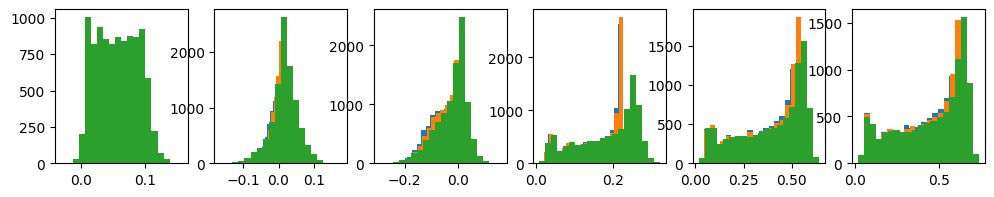

In [15]:
coef_iso_C_mu = np.array(coef_iso_C_mu)
coef_iso_D_mu = np.array(coef_iso_D_mu)
coef_iso_Fem_mu = np.array(coef_iso_Fem_mu)

fig,ax = plt.subplots(1,6,figsize=(12, 2))
ax = ax.flatten()

for r in range(6):
    ax[r].hist(coef_iso_C_mu[:,r,1],bins=20)
    ax[r].hist(coef_iso_D_mu[:,r,1],bins=20)
    ax[r].hist(coef_iso_Fem_mu[:,r,1],bins=20)
plt.show()

In [16]:
mfa_kappa = []
mfa_mu = []
for r in range(6):
    kappa = [VE['mfa_iso'][r][0] for VE in VoidSmall_parsed_labels]
    mu = [VE['mfa_iso'][r][1] for VE in VoidSmall_parsed_labels]
    mfa_kappa.append(kappa)
    mfa_mu.append(mu)

mfa_kappa = np.array(mfa_kappa).transpose()
mfa_mu = np.array(mfa_mu).transpose()

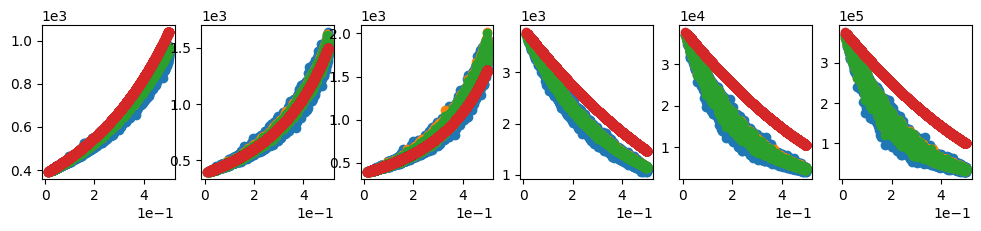

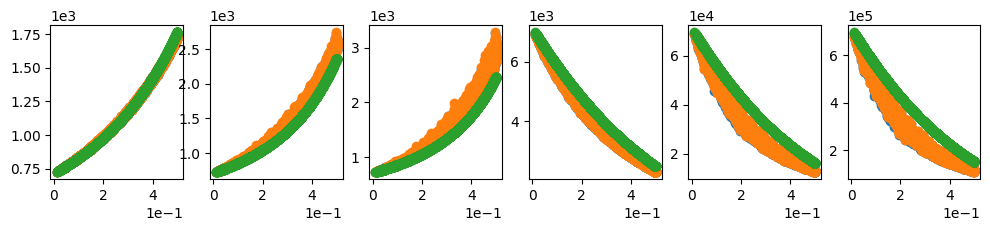

In [17]:
fig,ax = plt.subplots(1,6,figsize=(12, 2))
ax = ax.flatten()
for r in range(6):
    ax[r].scatter(true_vfs, Fem_mu[:,r])
    ax[r].scatter(true_vfs, C_mu[:,r])
    ax[r].scatter(true_vfs, D_mu[:,r]) 
    ax[r].scatter(true_vfs, mfa_mu[:,r])
    ax[r].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.show()

fig,ax = plt.subplots(1,6,figsize=(12, 2))
ax = ax.flatten()
for r in range(6):
    ax[r].scatter(true_vfs, D_kappa[:,r])
    ax[r].scatter(true_vfs, C_kappa[:,r])
    ax[r].scatter(true_vfs, mfa_kappa[:,r])
    ax[r].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.show()


In [18]:
for i in range(len(VoidSmall_parsed_labels)):
    VoidSmall_data_Voronoi[i]['iso_D_kappa'] = VoidSmall_parsed_labels[i]['iso_D_kappa']
    VoidSmall_data_Voronoi[i]['iso_C_mu'] = VoidSmall_parsed_labels[i]['iso_C_mu']
    VoidSmall_data_Voronoi[i]['iso_D_mu'] = VoidSmall_parsed_labels[i]['iso_D_mu']
    VoidSmall_data_Voronoi[i]['iso_Fem_mu'] = VoidSmall_parsed_labels[i]['iso_Fem_mu']
    VoidSmall_data_Voronoi[i]['mfa_iso'] = VoidSmall_parsed_labels[i]['mfa_iso']
    VoidSmall_data_Voronoi[i]['C_coefs_iso_C_mu'] = VoidSmall_parsed_labels[i]['C_coefs_iso_C_mu']
    VoidSmall_data_Voronoi[i]['C_coefs_iso_D_mu'] = VoidSmall_parsed_labels[i]['C_coefs_iso_D_mu']
    VoidSmall_data_Voronoi[i]['C_coefs_iso_Fem_mu'] = VoidSmall_parsed_labels[i]['C_coefs_iso_Fem_mu']

    VoidSmall_data_Voronoi[i]['C_coefs_diff'] = VoidSmall_parsed_labels[i]['C_coefs_diff']
    VoidSmall_data_Voronoi[i]['C_coefs_mt'] = VoidSmall_parsed_labels[i]['C_coefs_mt']
    VoidSmall_data_Voronoi[i]['C_coefs_sc'] = VoidSmall_parsed_labels[i]['C_coefs_sc']
    VoidSmall_data_Voronoi[i]['C_coefs_hsp'] = VoidSmall_parsed_labels[i]['C_coefs_hsp']
    VoidSmall_data_Voronoi[i]['C_coefs_hsn'] = VoidSmall_parsed_labels[i]['C_coefs_hsn']
    VoidSmall_data_Voronoi[i]['C_coefs_r'] = VoidSmall_parsed_labels[i]['C_coefs_r']
    VoidSmall_data_Voronoi[i]['C_coefs_v'] = VoidSmall_parsed_labels[i]['C_coefs_v']
    #VoidSmall_data_Voronoi[i]['C_fem'] = VoidSmall_parsed_labels[i]['C_fem']
    #VoidSmall_data_Voronoi[i]['C_mfa'] = VoidSmall_parsed_labels[i]['C_mfa']
    VoidSmall_data_Voronoi[i]['C_diff'] = VoidSmall_parsed_labels[i]['C_diff']
    VoidSmall_data_Voronoi[i]['C_mt'] = VoidSmall_parsed_labels[i]['C_mt']
    VoidSmall_data_Voronoi[i]['C_sc'] = VoidSmall_parsed_labels[i]['C_sc']
    VoidSmall_data_Voronoi[i]['C_hsp'] = VoidSmall_parsed_labels[i]['C_hsp']
    VoidSmall_data_Voronoi[i]['C_hsn'] = VoidSmall_parsed_labels[i]['C_hsn']
    VoidSmall_data_Voronoi[i]['C_r'] = VoidSmall_parsed_labels[i]['C_r']
    VoidSmall_data_Voronoi[i]['C_v'] = VoidSmall_parsed_labels[i]['C_v']
    VoidSmall_data_Voronoi[i]['img'] = VoidSmall_parsed_labels[i]['img']

In [19]:
filtered_data_list = []
for i in range(len(VoidSmall_data_Voronoi)):
    # Keep only centroids, Vf and C_coefs_diff
    filtered_data = {
        'centroids': VoidSmall_data_Voronoi[i]['centroids'],
        'C_coefs_diff': VoidSmall_data_Voronoi[i]['C_coefs_diff']
    }
    filtered_data_list.append(filtered_data)

with open('VoidSmall_data_C_coefs_diff.pkl', 'wb') as f:
    pickle.dump(filtered_data_list, f)

In [20]:
filtered_data_list = []
for i in range(len(VoidSmall_data_Voronoi)):
    # Keep only centroids, Vf and C_coefs_diff
    filtered_data = {
        'centroids': VoidSmall_data_Voronoi[i]['centroids'],
        'C_coefs_iso_C_mu': VoidSmall_data_Voronoi[i]['C_coefs_iso_C_mu']
    }
    filtered_data_list.append(filtered_data)

with open('VoidSmall_data_C_coefs_iso_C_mu.pkl', 'wb') as f:
    pickle.dump(filtered_data_list, f)

In [21]:
filtered_data_list = []
for i in range(len(VoidSmall_data_Voronoi)):
    # Keep only centroids, Vf and C_coefs_diff
    filtered_data = {
        'centroids': VoidSmall_data_Voronoi[i]['centroids'],
        'C_coefs_iso_D_mu': VoidSmall_data_Voronoi[i]['C_coefs_iso_D_mu']
    }
    filtered_data_list.append(filtered_data)

with open('VoidSmall_data_C_coefs_iso_D_mu.pkl', 'wb') as f:
    pickle.dump(filtered_data_list, f)

In [27]:
filtered_data_list = []
for i in range(len(VoidSmall_data_Voronoi)):
    # Keep only centroids, Vf and C_coefs_diff
    filtered_data = {
        'centroids': VoidSmall_data_Voronoi[i]['centroids'],
        'C_coefs_iso_Fem_mu': VoidSmall_data_Voronoi[i]['C_coefs_iso_Fem_mu']
    }
    filtered_data_list.append(filtered_data)

with open('VoidSmall_data_C_coefs_iso_Fem_mu.pkl', 'wb') as f:
    pickle.dump(filtered_data_list, f)

In [28]:
VoidSmall_data_Voronoi[i]['C_coefs_iso_Fem_mu']

[[-0.001312962953332164, 0.04158558310882576],
 [-0.019862735992288272, 0.03834160910148521],
 [-0.028806757889456414, 0.032036258365190085],
 [0.05945681462206431, 0.1359060205400756],
 [0.1334835893906362, 0.26544334689980276],
 [0.1497663390878251, 0.29210004000522083]]

In [23]:
with open('VoidSmall_data.pkl', 'wb') as f:
    pickle.dump(VoidSmall_data_Voronoi, f)

In [24]:
for key in VoidSmall_data_Voronoi[0].keys():
    print(key)

centroids
centroids_n
Vf
num_centroids
r_inclusion
C_coefs
C_fem
C_mfa
contrast_ratios
index
statistics
voronoi_data
edge_list
cell_centers
graph_index
cell_index
x
pos
iso_D_kappa
iso_C_mu
iso_D_mu
iso_Fem_mu
mfa_iso
C_coefs_iso_C_mu
C_coefs_iso_D_mu
C_coefs_iso_Fem_mu
C_coefs_diff
C_coefs_mt
C_coefs_sc
C_coefs_hsp
C_coefs_hsn
C_coefs_r
C_coefs_v
C_diff
C_mt
C_sc
C_hsp
C_hsn
C_r
C_v
img


In [25]:
# with open('VoidSmall_data_iso.pkl', 'wb') as f:
#     pickle.dump(VoidSmall_data_Voronoi, f)

In [26]:
# import pickle
# with open('micro2d_data_voronoi.pkl', 'wb') as f:
#     pickle.dump(VoidSmall_all_data_Voronoi, f)